# Image Segmentation by Supervised Learning

## import libraries

In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [197]:
directory_data  = './'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## hyper-parameters

In [198]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 600
size_minibatch  = 50
learning_rate   = 0.05
weight_decay    = 0.009

## custom data loader for the PyTorch framework

In [199]:
class dataset(Dataset):
    
    def __init__(self, image, label, transform=0):
        
        self.image  = image
        self.label  = label 
        self.transform = transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)

        image   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
        label   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)

        if self.transform == 1:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,2])
            label = torch.flip(label, [0,2])
            
            #
            # ==================================================

        if self.transform == 2:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,1])
            label = torch.flip(label, [0,1])
            
            #
            # ==================================================
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [200]:
dataset_train_transform = dataset(x_train, y_train, transform=1)
dataset_train_transform_ud = dataset(x_train, y_train, transform=2)
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train_transform_ud  = DataLoader(dataset_train_transform_ud, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 64, 64])
shape of the label in the training dataset: torch.Size([1, 64, 64])


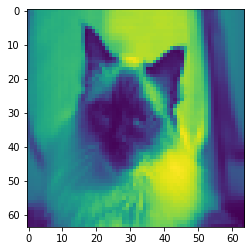

*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 64, 64])
shape of the label in the testing dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the training transform dataset: torch.Size([1, 64, 64])
shape of the label in the training transform dataset: torch.Size([1, 64, 64])


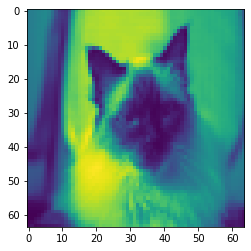

*******************************************************************


In [201]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
(image_train_transform, label_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
plt.imshow(image_train[0], interpolation='nearest')
plt.show()
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')
print('shape of the image in the training transform dataset:', image_train_transform.shape)
print('shape of the label in the training transform dataset:', label_train_transform.shape)
plt.imshow(image_train_transform[0], interpolation='nearest')
plt.show()
print('*******************************************************************')

## class for the neural network 

In [202]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        self.activationReLu		= nn.ReLU(inplace=True)
        self.activation		= nn.LeakyReLU(0.1)
        self.activation_out	= nn.Sigmoid()
        self.skip = nn.Identity()
      
        self.mp = nn.MaxPool2d(2,2)
        self.us = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv_e1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e1.weight)
        self.ebn1 = nn.BatchNorm2d(16)

        self.conv_e2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e2.weight)
        self.ebn2 = nn.BatchNorm2d(32)

        self.conv_e3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e3.weight)
        self.ebn3 = nn.BatchNorm2d(64)

        self.conv_e4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e4.weight)
        self.ebn4 = nn.BatchNorm2d(128)

        self.conv_e5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e5.weight)
        self.ebn5 = nn.BatchNorm2d(256)

        self.conv_e6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e6.weight)
        self.ebn6  = nn.BatchNorm2d(512)

        self.conv_e7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e7.weight)
        self.ebn7  = nn.BatchNorm2d(512)



        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.conv_d1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d1.weight)
        self.dbn1 = nn.BatchNorm2d(256)

        self.conv_d2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d2.weight)
        self.dbn2 = nn.BatchNorm2d(128)

        self.conv_d3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d3.weight)
        self.dbn3 = nn.BatchNorm2d(64)

        self.conv_d4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d4.weight)
        self.dbn4 = nn.BatchNorm2d(32)

        self.conv_d5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d5.weight)
        self.dbn5 = nn.BatchNorm2d(16)

        self.conv_d6 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d6.weight)

    def forward(self,x):
        out = self.conv_e1(x)
        out = self.ebn1(out)
        out = self.activation(out)
        res1 = out
        out = self.mp(out)

        out = self.conv_e2(out)
        out = self.ebn2(out)
        out = self.activation(out)
        res2 = out

        out = self.conv_e3(out)
        out = self.ebn3(out)
        out = self.activation(out)
        res3 = out

        out = self.conv_e4(out)
        out = self.ebn4(out)
        out = self.activation(out)
        res4 = out

        out = self.conv_e5(out)
        out = self.ebn5(out)
        out = self.activation(out)
        res5 = out
        out = self.mp(out)
        

        out = self.conv_e6(out)
        out = self.ebn6(out)
        out = self.activation(out)
        res6 = out
        out = self.mp(out)

        out = self.conv_e7(out)
        out = self.ebn7(out)
        out = self.activation(out)        

        out = self.us(out)
        out = out + self.skip(res6)
        out = self.conv_d1(out)
        out = self.dbn1(out)
        out = self.activation(out)
        

        out = self.us(out)
        out = out + self.skip(res5)
        out = self.conv_d2(out)
        out = self.dbn2(out)
        out = self.activation(out)
        
        out = out + self.skip(res4)
        out = self.conv_d3(out)
        out = self.dbn3(out)
        out = self.activation(out)

        out = out + self.skip(res3)
        out = self.conv_d4(out)
        out = self.dbn4(out)
        out = self.activation(out)

        out = out + self.skip(res2)
        out = self.conv_d5(out)
        out = self.dbn5(out)
        out = self.activation(out)
        
        
        out = self.us(out)
        out = out + self.skip(res1)
        out = self.conv_d6(out)
        out = self.activation_out(out)

        return out

In [203]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()

#         # -------------------------------------------------
#         # Encoder
#         # -------------------------------------------------
        
#         self.e_layers = nn.Sequential(
#                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),  
#                         nn.BatchNorm2d(16),
#                         nn.ReLU(),
#                         nn.MaxPool2d(2,2),
                        
#                         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
#                         nn.BatchNorm2d(32),
#                         nn.ReLU(),
#                         # nn.MaxPool2d(2,2),
                        

#                         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(64),
# 												nn.ReLU(),
#                         # nn.MaxPool2d(2,2),

#                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(128),
# 												nn.ReLU(),
#                         # nn.MaxPool2d(2,2),

#                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(256),
# 												nn.ReLU(),
#                         nn.MaxPool2d(2,2),

#                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(512),
# 												nn.ReLU(),
#                         nn.MaxPool2d(2,2),
                        
#                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(512),
# 												nn.ReLU(),
                       

#         )

#         # -------------------------------------------------
#         # Decoder
#         # -------------------------------------------------

        
#         self.d_layers = nn.Sequential(
          
#                         # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#                         # nn.BatchNorm2d(256),
# 												# nn.ReLU(),

#                         nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(256),
# 												nn.ReLU(),

#                         nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(128),
# 												nn.ReLU(),
                        
#                         # nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(64),
# 												nn.ReLU(),


#                         # nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(32),
# 												nn.ReLU(),

#                         # nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(16),
# 												nn.ReLU(),
                        
#                         nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.Sigmoid(),
#         )

#         # -------------------------------------------------
#         # Network
#         # -------------------------------------------------
#         self.network = nn.Sequential(
#                         self.e_layers, 
#                         self.d_layers,
#         )

#         self.initialize_weight()

#     def forward(self,x):
#         out = self.network(x)
#         return out

#     # ======================================================================
#     # initialize weights
#     # ======================================================================
#     def initialize_weight(self): 
#         for m in self.network.modules():

#             if isinstance(m, nn.Conv2d):
#                 m.reset_parameters()
#                 # xavier(m.weight.data)
#                 # xavier(m.bias.data)

#             elif isinstance(m, nn.BatchNorm2d):
#                 m.reset_parameters()
#                 # xavier(m.weight.data)
#                 # xavier(m.bias.data)

#             elif isinstance(m, nn.Linear):
#                 m.reset_parameters()

## build network

In [204]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [205]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [206]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    mse = nn.MSELoss()
    loss = mse(label, prediction)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [207]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [208]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [209]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [210]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [211]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']
    print(accuracy_mean_test[i])

  0%|▏                                                                                 | 1/600 [00:02<28:10,  2.82s/it]

48.4202475405436


  0%|▎                                                                                 | 2/600 [00:05<27:46,  2.79s/it]

33.133940424987586


  0%|▍                                                                                 | 3/600 [00:08<28:58,  2.91s/it]

34.49089089772592


  1%|▌                                                                                 | 4/600 [00:11<30:36,  3.08s/it]

45.13632981777428


  1%|▋                                                                                 | 5/600 [00:15<32:13,  3.25s/it]

58.83098479474721


  1%|▊                                                                                 | 6/600 [00:19<33:00,  3.33s/it]

60.550779941442


  1%|▉                                                                                 | 7/600 [00:22<33:57,  3.44s/it]

58.95569305380134


  1%|█                                                                                 | 8/600 [00:26<34:09,  3.46s/it]

61.048285573271635


  2%|█▏                                                                                | 9/600 [00:29<32:35,  3.31s/it]

60.7884065539142


  2%|█▎                                                                               | 10/600 [00:31<31:04,  3.16s/it]

61.81358568172743


  2%|█▍                                                                               | 11/600 [00:34<29:55,  3.05s/it]

62.36864380746623


  2%|█▌                                                                               | 12/600 [00:37<29:05,  2.97s/it]

57.57055945927035


  2%|█▊                                                                               | 13/600 [00:40<28:30,  2.91s/it]

61.081824686327955


  2%|█▉                                                                               | 14/600 [00:43<28:02,  2.87s/it]

61.935139384737894


  2%|██                                                                               | 15/600 [00:45<27:38,  2.83s/it]

62.030662981381994


  3%|██▏                                                                              | 16/600 [00:48<27:25,  2.82s/it]

63.30116113825345


  3%|██▎                                                                              | 17/600 [00:51<27:18,  2.81s/it]

63.55470593568985


  3%|██▍                                                                              | 18/600 [00:54<29:17,  3.02s/it]

65.62558957262033


  3%|██▌                                                                              | 19/600 [00:58<30:36,  3.16s/it]

58.788171855816174


  3%|██▋                                                                              | 20/600 [01:02<31:43,  3.28s/it]

51.328567934124656


  4%|██▊                                                                              | 21/600 [01:05<32:24,  3.36s/it]

65.06639767172561


  4%|██▉                                                                              | 22/600 [01:09<32:54,  3.42s/it]

57.96292113404402


  4%|███                                                                              | 23/600 [01:12<33:13,  3.45s/it]

64.2251424663125


  4%|███▏                                                                             | 24/600 [01:16<33:16,  3.47s/it]

60.057145050964266


  4%|███▍                                                                             | 25/600 [01:19<33:15,  3.47s/it]

37.97078947473624


  4%|███▌                                                                             | 26/600 [01:23<33:24,  3.49s/it]

62.28349103863238


  4%|███▋                                                                             | 27/600 [01:26<33:17,  3.49s/it]

48.14521711534485


  5%|███▊                                                                             | 28/600 [01:30<33:20,  3.50s/it]

57.42902715477963


  5%|███▉                                                                             | 29/600 [01:33<33:21,  3.50s/it]

67.06737682727181


  5%|████                                                                             | 30/600 [01:37<33:22,  3.51s/it]

62.27204588818818


  5%|████▏                                                                            | 31/600 [01:40<33:10,  3.50s/it]

63.80243504588006


  5%|████▎                                                                            | 32/600 [01:44<33:03,  3.49s/it]

65.68181162245236


  6%|████▍                                                                            | 33/600 [01:47<33:03,  3.50s/it]

48.62221843885926


  6%|████▌                                                                            | 34/600 [01:51<33:01,  3.50s/it]

48.56722362001919


  6%|████▋                                                                            | 35/600 [01:54<32:58,  3.50s/it]

61.36745303651081


  6%|████▊                                                                            | 36/600 [01:58<32:52,  3.50s/it]

64.74968876061843


  6%|████▉                                                                            | 37/600 [02:01<32:44,  3.49s/it]

67.68610404397872


  6%|█████▏                                                                           | 38/600 [02:05<32:43,  3.49s/it]

67.25900052284143


  6%|█████▎                                                                           | 39/600 [02:08<32:45,  3.50s/it]

64.15782559867178


  7%|█████▍                                                                           | 40/600 [02:12<32:42,  3.51s/it]

43.85574515940199


  7%|█████▌                                                                           | 41/600 [02:15<32:29,  3.49s/it]

66.49878544081872


  7%|█████▋                                                                           | 42/600 [02:18<31:37,  3.40s/it]

53.07616961880368


  7%|█████▊                                                                           | 43/600 [02:21<30:04,  3.24s/it]

60.300215079475294


  7%|█████▉                                                                           | 44/600 [02:24<28:56,  3.12s/it]

47.418521926481546


  8%|██████                                                                           | 45/600 [02:27<28:12,  3.05s/it]

63.42857286546598


  8%|██████▏                                                                          | 46/600 [02:30<28:07,  3.05s/it]

19.061231421303653


  8%|██████▎                                                                          | 47/600 [02:33<27:53,  3.03s/it]

56.19187828400336


  8%|██████▍                                                                          | 48/600 [02:36<27:34,  3.00s/it]

47.44274030874897


  8%|██████▌                                                                          | 49/600 [02:39<28:27,  3.10s/it]

64.5999864625903


  8%|██████▊                                                                          | 50/600 [02:43<29:05,  3.17s/it]

64.50501007679253


  8%|██████▉                                                                          | 51/600 [02:46<30:00,  3.28s/it]

62.74958542983282


  9%|███████                                                                          | 52/600 [02:50<30:44,  3.37s/it]

52.93427334259597


  9%|███████▏                                                                         | 53/600 [02:53<31:05,  3.41s/it]

66.11325204668816


  9%|███████▎                                                                         | 54/600 [02:57<31:26,  3.46s/it]

63.606302431309345


  9%|███████▍                                                                         | 55/600 [03:00<31:23,  3.46s/it]

53.05605575800851


  9%|███████▌                                                                         | 56/600 [03:04<31:52,  3.51s/it]

64.19829264174652


 10%|███████▋                                                                         | 57/600 [03:07<31:58,  3.53s/it]

64.27112243208875


 10%|███████▊                                                                         | 58/600 [03:11<31:48,  3.52s/it]

59.92190377830587


 10%|███████▉                                                                         | 59/600 [03:14<31:41,  3.51s/it]

41.26951086912351


 10%|████████                                                                         | 60/600 [03:18<31:37,  3.51s/it]

60.470207701570814


 10%|████████▏                                                                        | 61/600 [03:21<31:32,  3.51s/it]

64.15824446666966


 10%|████████▎                                                                        | 62/600 [03:25<31:28,  3.51s/it]

67.63605761339609


 10%|████████▌                                                                        | 63/600 [03:28<31:24,  3.51s/it]

56.074836489148474


 11%|████████▋                                                                        | 64/600 [03:32<31:18,  3.50s/it]

63.707049958177535


 11%|████████▊                                                                        | 65/600 [03:35<31:14,  3.50s/it]

67.74734324410299


 11%|████████▉                                                                        | 66/600 [03:39<31:15,  3.51s/it]

58.31884265761952


 11%|█████████                                                                        | 67/600 [03:43<31:18,  3.52s/it]

66.37779057359995


 11%|█████████▏                                                                       | 68/600 [03:46<31:21,  3.54s/it]

66.60410095617144


 12%|█████████▎                                                                       | 69/600 [03:50<31:19,  3.54s/it]

44.20499744001918


 12%|█████████▍                                                                       | 70/600 [03:53<31:12,  3.53s/it]

60.80801830896179


 12%|█████████▌                                                                       | 71/600 [03:57<31:12,  3.54s/it]

68.04986433741792


 12%|█████████▋                                                                       | 72/600 [04:00<31:17,  3.56s/it]

65.60640449131326


 12%|█████████▊                                                                       | 73/600 [04:04<31:02,  3.53s/it]

68.35266179716608


 12%|█████████▉                                                                       | 74/600 [04:07<29:30,  3.37s/it]

61.589268466548816


 12%|██████████▏                                                                      | 75/600 [04:10<28:53,  3.30s/it]

67.75005580345994


 13%|██████████▎                                                                      | 76/600 [04:13<29:01,  3.32s/it]

67.40718748324608


 13%|██████████▍                                                                      | 77/600 [04:17<29:17,  3.36s/it]

55.97329362578226


 13%|██████████▌                                                                      | 78/600 [04:20<29:31,  3.39s/it]

26.29961692720711


 13%|██████████▋                                                                      | 79/600 [04:24<30:03,  3.46s/it]

67.70330821928732


 13%|██████████▊                                                                      | 80/600 [04:27<30:23,  3.51s/it]

63.53464564787425


 14%|██████████▉                                                                      | 81/600 [04:31<30:35,  3.54s/it]

66.48880247206873


 14%|███████████                                                                      | 82/600 [04:34<30:07,  3.49s/it]

68.9291316315261


 14%|███████████▏                                                                     | 83/600 [04:37<28:48,  3.34s/it]

59.874747548517774


 14%|███████████▎                                                                     | 84/600 [04:40<27:54,  3.25s/it]

61.16583347790441


 14%|███████████▍                                                                     | 85/600 [04:43<27:22,  3.19s/it]

63.84732158047175


 14%|███████████▌                                                                     | 86/600 [04:47<28:06,  3.28s/it]

64.31359185554724


 14%|███████████▋                                                                     | 87/600 [04:50<28:38,  3.35s/it]

61.41390709304875


 15%|███████████▉                                                                     | 88/600 [04:54<28:58,  3.39s/it]

42.33458930775427


 15%|████████████                                                                     | 89/600 [04:57<27:51,  3.27s/it]

62.02766583549416


 15%|████████████▏                                                                    | 90/600 [05:00<26:37,  3.13s/it]

68.81612156223471


 15%|████████████▎                                                                    | 91/600 [05:03<26:20,  3.10s/it]

52.6701080420723


 15%|████████████▍                                                                    | 92/600 [05:06<26:06,  3.08s/it]

54.51757504947648


 16%|████████████▌                                                                    | 93/600 [05:09<26:04,  3.09s/it]

65.01948241145294


 16%|████████████▋                                                                    | 94/600 [05:12<26:09,  3.10s/it]

37.01145432421781


 16%|████████████▊                                                                    | 95/600 [05:15<26:31,  3.15s/it]

63.70179770198729


 16%|████████████▉                                                                    | 96/600 [05:19<26:38,  3.17s/it]

53.51985461971563


 16%|█████████████                                                                    | 97/600 [05:22<27:24,  3.27s/it]

69.79169455582621


 16%|█████████████▏                                                                   | 98/600 [05:25<26:51,  3.21s/it]

67.81899778092014


 16%|█████████████▎                                                                   | 99/600 [05:29<27:44,  3.32s/it]

63.536965536617416


 17%|█████████████▎                                                                  | 100/600 [05:32<28:17,  3.40s/it]

67.16893056753361


 17%|█████████████▍                                                                  | 101/600 [05:36<28:38,  3.44s/it]

65.16178158317052


 17%|█████████████▌                                                                  | 102/600 [05:39<28:38,  3.45s/it]

66.28716581443385


 17%|█████████████▋                                                                  | 103/600 [05:43<28:54,  3.49s/it]

67.31111928055444


 17%|█████████████▊                                                                  | 104/600 [05:46<29:07,  3.52s/it]

60.442117532880275


 18%|██████████████                                                                  | 105/600 [05:50<29:22,  3.56s/it]

35.62006185032669


 18%|██████████████▏                                                                 | 106/600 [05:54<29:19,  3.56s/it]

35.26192545604681


 18%|██████████████▎                                                                 | 107/600 [05:57<29:24,  3.58s/it]

64.62934897984178


 18%|██████████████▍                                                                 | 108/600 [06:01<29:34,  3.61s/it]

62.66647615347509


 18%|██████████████▌                                                                 | 109/600 [06:05<29:45,  3.64s/it]

66.1653314013175


 18%|██████████████▋                                                                 | 110/600 [06:08<29:53,  3.66s/it]

66.55773315635861


 18%|██████████████▊                                                                 | 111/600 [06:12<29:36,  3.63s/it]

60.646083013547326


 19%|██████████████▉                                                                 | 112/600 [06:16<29:33,  3.63s/it]

68.43421364875448


 19%|███████████████                                                                 | 113/600 [06:19<29:23,  3.62s/it]

58.48240159617862


 19%|███████████████▏                                                                | 114/600 [06:23<29:14,  3.61s/it]

27.700683012574657


 19%|███████████████▎                                                                | 115/600 [06:26<29:20,  3.63s/it]

13.016526861969497


 19%|███████████████▍                                                                | 116/600 [06:30<29:23,  3.64s/it]

64.13289034685569


 20%|███████████████▌                                                                | 117/600 [06:34<29:23,  3.65s/it]

66.67264304352986


 20%|███████████████▋                                                                | 118/600 [06:37<29:20,  3.65s/it]

65.51864356650606


 20%|███████████████▊                                                                | 119/600 [06:41<29:16,  3.65s/it]

68.39907473302944


 20%|████████████████                                                                | 120/600 [06:45<29:13,  3.65s/it]

60.635639226690905


 20%|████████████████▏                                                               | 121/600 [06:48<28:48,  3.61s/it]

66.47556943881756


 20%|████████████████▎                                                               | 122/600 [06:52<28:40,  3.60s/it]

67.28336900212894


 20%|████████████████▍                                                               | 123/600 [06:55<28:30,  3.59s/it]

61.76146398274639


 21%|████████████████▌                                                               | 124/600 [06:59<28:35,  3.60s/it]

67.70934589521329


 21%|████████████████▋                                                               | 125/600 [07:03<28:38,  3.62s/it]

64.54308570126709


 21%|████████████████▊                                                               | 126/600 [07:06<28:36,  3.62s/it]

63.276687150295146


 21%|████████████████▉                                                               | 127/600 [07:10<28:32,  3.62s/it]

67.3366485883706


 21%|█████████████████                                                               | 128/600 [07:14<28:20,  3.60s/it]

68.89173948249282


 22%|█████████████████▏                                                              | 129/600 [07:17<28:00,  3.57s/it]

68.4066407730347


 22%|█████████████████▎                                                              | 130/600 [07:21<27:56,  3.57s/it]

51.348136405291754


 22%|█████████████████▍                                                              | 131/600 [07:24<28:00,  3.58s/it]

66.88256218712019


 22%|█████████████████▌                                                              | 132/600 [07:28<28:11,  3.61s/it]

57.400651700964886


 22%|█████████████████▋                                                              | 133/600 [07:32<28:15,  3.63s/it]

57.66239554421233


 22%|█████████████████▊                                                              | 134/600 [07:35<28:18,  3.64s/it]

62.560849162294254


 22%|██████████████████                                                              | 135/600 [07:39<28:17,  3.65s/it]

68.68247305881441


 23%|██████████████████▏                                                             | 136/600 [07:43<28:17,  3.66s/it]

69.25938843103805


 23%|██████████████████▎                                                             | 137/600 [07:46<28:14,  3.66s/it]

68.1658951378408


 23%|██████████████████▍                                                             | 138/600 [07:50<28:14,  3.67s/it]

50.255807493329016


 23%|██████████████████▌                                                             | 139/600 [07:54<28:10,  3.67s/it]

63.04800748394957


 23%|██████████████████▋                                                             | 140/600 [07:57<28:08,  3.67s/it]

67.00280739836182


 24%|██████████████████▊                                                             | 141/600 [08:01<28:04,  3.67s/it]

63.91531940241414


 24%|██████████████████▉                                                             | 142/600 [08:05<28:02,  3.67s/it]

55.962260583019216


 24%|███████████████████                                                             | 143/600 [08:08<27:58,  3.67s/it]

65.82199042246866


 24%|███████████████████▏                                                            | 144/600 [08:12<27:53,  3.67s/it]

55.20199521289505


 24%|███████████████████▎                                                            | 145/600 [08:16<27:48,  3.67s/it]

69.17018045100943


 24%|███████████████████▍                                                            | 146/600 [08:19<27:45,  3.67s/it]

63.898929228280196


 24%|███████████████████▌                                                            | 147/600 [08:23<27:41,  3.67s/it]

61.75756584785793


 25%|███████████████████▋                                                            | 148/600 [08:27<27:37,  3.67s/it]

68.11476020723765


 25%|███████████████████▊                                                            | 149/600 [08:30<27:34,  3.67s/it]

63.889435912014676


 25%|████████████████████                                                            | 150/600 [08:34<27:33,  3.67s/it]

66.21793397410127


 25%|████████████████████▏                                                           | 151/600 [08:38<27:29,  3.67s/it]

64.90939644822109


 25%|████████████████████▎                                                           | 152/600 [08:41<27:25,  3.67s/it]

69.05995239339495


 26%|████████████████████▍                                                           | 153/600 [08:45<27:21,  3.67s/it]

69.68617687582305


 26%|████████████████████▌                                                           | 154/600 [08:49<27:16,  3.67s/it]

66.28420491081218


 26%|████████████████████▋                                                           | 155/600 [08:52<27:11,  3.67s/it]

69.44488700817915


 26%|████████████████████▊                                                           | 156/600 [08:56<27:08,  3.67s/it]

68.93673960182572


 26%|████████████████████▉                                                           | 157/600 [09:00<27:04,  3.67s/it]

67.06975927788585


 26%|█████████████████████                                                           | 158/600 [09:03<27:01,  3.67s/it]

67.34549726534783


 26%|█████████████████████▏                                                          | 159/600 [09:07<26:56,  3.67s/it]

60.02366016320786


 27%|█████████████████████▎                                                          | 160/600 [09:11<26:48,  3.65s/it]

60.186871709379815


 27%|█████████████████████▍                                                          | 161/600 [09:14<26:46,  3.66s/it]

42.318367006810874


 27%|█████████████████████▌                                                          | 162/600 [09:18<26:43,  3.66s/it]

33.07422059534046


 27%|█████████████████████▋                                                          | 163/600 [09:22<26:42,  3.67s/it]

69.12320920129558


 27%|█████████████████████▊                                                          | 164/600 [09:25<26:38,  3.67s/it]

67.04611048857382


 28%|██████████████████████                                                          | 165/600 [09:29<26:33,  3.66s/it]

69.40926533077096


 28%|██████████████████████▏                                                         | 166/600 [09:33<26:29,  3.66s/it]

69.41779492758377


 28%|██████████████████████▎                                                         | 167/600 [09:36<26:26,  3.67s/it]

68.24075840893171


 28%|██████████████████████▍                                                         | 168/600 [09:40<26:23,  3.67s/it]

68.90899212617038


 28%|██████████████████████▌                                                         | 169/600 [09:44<26:21,  3.67s/it]

69.58144614620586


 28%|██████████████████████▋                                                         | 170/600 [09:47<26:18,  3.67s/it]

62.065091445614236


 28%|██████████████████████▊                                                         | 171/600 [09:51<26:13,  3.67s/it]

67.84688842419823


 29%|██████████████████████▉                                                         | 172/600 [09:55<26:11,  3.67s/it]

68.96315298819071


 29%|███████████████████████                                                         | 173/600 [09:58<26:04,  3.66s/it]

63.53448619225034


 29%|███████████████████████▏                                                        | 174/600 [10:02<26:04,  3.67s/it]

66.69915997629182


 29%|███████████████████████▎                                                        | 175/600 [10:06<26:00,  3.67s/it]

60.38315376892462


 29%|███████████████████████▍                                                        | 176/600 [10:09<25:55,  3.67s/it]

68.9909948189152


 30%|███████████████████████▌                                                        | 177/600 [10:13<25:53,  3.67s/it]

69.14637260601245


 30%|███████████████████████▋                                                        | 178/600 [10:17<25:51,  3.68s/it]

58.28020080973481


 30%|███████████████████████▊                                                        | 179/600 [10:20<25:41,  3.66s/it]

17.973847574833165


 30%|████████████████████████                                                        | 180/600 [10:24<25:39,  3.67s/it]

63.774222855278595


 30%|████████████████████████▏                                                       | 181/600 [10:28<25:35,  3.66s/it]

59.46089237941057


 30%|████████████████████████▎                                                       | 182/600 [10:31<25:31,  3.66s/it]

62.63582417199332


 30%|████████████████████████▍                                                       | 183/600 [10:35<25:29,  3.67s/it]

69.5383852860796


 31%|████████████████████████▌                                                       | 184/600 [10:39<25:26,  3.67s/it]

69.25801217309674


 31%|████████████████████████▋                                                       | 185/600 [10:42<25:20,  3.66s/it]

69.19475279047224


 31%|████████████████████████▊                                                       | 186/600 [10:46<25:17,  3.67s/it]

66.37427122084245


 31%|████████████████████████▉                                                       | 187/600 [10:50<25:10,  3.66s/it]

67.62016613888052


 31%|█████████████████████████                                                       | 188/600 [10:53<25:09,  3.66s/it]

67.06933383325728


 32%|█████████████████████████▏                                                      | 189/600 [10:57<25:06,  3.66s/it]

68.7272171063097


 32%|█████████████████████████▎                                                      | 190/600 [11:01<25:03,  3.67s/it]

69.20420847576796


 32%|█████████████████████████▍                                                      | 191/600 [11:04<25:02,  3.67s/it]

65.23012983188423


 32%|█████████████████████████▌                                                      | 192/600 [11:08<24:59,  3.68s/it]

64.78345330114786


 32%|█████████████████████████▋                                                      | 193/600 [11:12<24:55,  3.67s/it]

67.74097028523919


 32%|█████████████████████████▊                                                      | 194/600 [11:15<24:52,  3.68s/it]

68.03832444949008


 32%|██████████████████████████                                                      | 195/600 [11:19<24:48,  3.68s/it]

55.71745875687909


 33%|██████████████████████████▏                                                     | 196/600 [11:23<24:42,  3.67s/it]

60.83290740197958


 33%|██████████████████████████▎                                                     | 197/600 [11:26<24:40,  3.67s/it]

57.07628215755686


 33%|██████████████████████████▍                                                     | 198/600 [11:30<24:36,  3.67s/it]

64.8414101556075


 33%|██████████████████████████▌                                                     | 199/600 [11:34<24:29,  3.66s/it]

66.50077355524638


 33%|██████████████████████████▋                                                     | 200/600 [11:37<24:27,  3.67s/it]

70.04378025494897


 34%|██████████████████████████▊                                                     | 201/600 [11:41<24:24,  3.67s/it]

66.9092476018229


 34%|██████████████████████████▉                                                     | 202/600 [11:45<24:19,  3.67s/it]

67.37718200933139


 34%|███████████████████████████                                                     | 203/600 [11:48<24:16,  3.67s/it]

68.46275601090201


 34%|███████████████████████████▏                                                    | 204/600 [11:52<24:12,  3.67s/it]

68.39451810865886


 34%|███████████████████████████▎                                                    | 205/600 [11:56<24:08,  3.67s/it]

70.0667373191724


 34%|███████████████████████████▍                                                    | 206/600 [11:59<24:05,  3.67s/it]

60.925821791539946


 34%|███████████████████████████▌                                                    | 207/600 [12:03<24:00,  3.67s/it]

67.38161684096382


 35%|███████████████████████████▋                                                    | 208/600 [12:07<23:58,  3.67s/it]

62.21434063902515


 35%|███████████████████████████▊                                                    | 209/600 [12:10<23:53,  3.67s/it]

69.10472277395218


 35%|████████████████████████████                                                    | 210/600 [12:14<23:50,  3.67s/it]

66.17027801049632


 35%|████████████████████████████▏                                                   | 211/600 [12:18<23:47,  3.67s/it]

67.308115308522


 35%|████████████████████████████▎                                                   | 212/600 [12:21<23:42,  3.67s/it]

68.66394857057941


 36%|████████████████████████████▍                                                   | 213/600 [12:25<23:38,  3.67s/it]

68.14947843065121


 36%|████████████████████████████▌                                                   | 214/600 [12:29<23:36,  3.67s/it]

69.92833044686301


 36%|████████████████████████████▋                                                   | 215/600 [12:32<23:32,  3.67s/it]

69.23830098047135


 36%|████████████████████████████▊                                                   | 216/600 [12:36<23:28,  3.67s/it]

67.71383216993036


 36%|████████████████████████████▉                                                   | 217/600 [12:40<23:25,  3.67s/it]

63.738509727090744


 36%|█████████████████████████████                                                   | 218/600 [12:43<23:22,  3.67s/it]

52.615914513892065


 36%|█████████████████████████████▏                                                  | 219/600 [12:47<23:18,  3.67s/it]

60.31311332722023


 37%|█████████████████████████████▎                                                  | 220/600 [12:51<23:15,  3.67s/it]

63.60332541790342


 37%|█████████████████████████████▍                                                  | 221/600 [12:54<23:10,  3.67s/it]

41.034990666509074


 37%|█████████████████████████████▌                                                  | 222/600 [12:58<23:07,  3.67s/it]

59.920216721402056


 37%|█████████████████████████████▋                                                  | 223/600 [13:02<23:04,  3.67s/it]

69.56451654029652


 37%|█████████████████████████████▊                                                  | 224/600 [13:05<23:01,  3.67s/it]

70.40792218076147


 38%|██████████████████████████████                                                  | 225/600 [13:09<22:58,  3.67s/it]

68.00149496029563


 38%|██████████████████████████████▏                                                 | 226/600 [13:13<22:52,  3.67s/it]

69.16419404914997


 38%|██████████████████████████████▎                                                 | 227/600 [13:16<22:49,  3.67s/it]

68.11809987048858


 38%|██████████████████████████████▍                                                 | 228/600 [13:20<22:44,  3.67s/it]

66.27257124748175


 38%|██████████████████████████████▌                                                 | 229/600 [13:24<22:41,  3.67s/it]

66.27641494973848


 38%|██████████████████████████████▋                                                 | 230/600 [13:27<22:37,  3.67s/it]

69.89997649902628


 38%|██████████████████████████████▊                                                 | 231/600 [13:31<22:34,  3.67s/it]

68.84142645048355


 39%|██████████████████████████████▉                                                 | 232/600 [13:35<22:31,  3.67s/it]

69.56982101752997


 39%|███████████████████████████████                                                 | 233/600 [13:38<22:29,  3.68s/it]

65.22953485303292


 39%|███████████████████████████████▏                                                | 234/600 [13:42<22:24,  3.67s/it]

67.64302595586463


 39%|███████████████████████████████▎                                                | 235/600 [13:46<22:19,  3.67s/it]

69.39905674166971


 39%|███████████████████████████████▍                                                | 236/600 [13:49<22:16,  3.67s/it]

68.42443719165172


 40%|███████████████████████████████▌                                                | 237/600 [13:53<22:12,  3.67s/it]

56.56804669321049


 40%|███████████████████████████████▋                                                | 238/600 [13:57<22:07,  3.67s/it]

65.38633593238492


 40%|███████████████████████████████▊                                                | 239/600 [14:00<22:06,  3.67s/it]

67.91180947352018


 40%|████████████████████████████████                                                | 240/600 [14:04<22:03,  3.68s/it]

66.62431883640333


 40%|████████████████████████████████▏                                               | 241/600 [14:08<21:58,  3.67s/it]

65.52815644155419


 40%|████████████████████████████████▎                                               | 242/600 [14:12<21:55,  3.67s/it]

32.63837658482571


 40%|████████████████████████████████▍                                               | 243/600 [14:15<21:52,  3.68s/it]

60.532780370129096


 41%|████████████████████████████████▌                                               | 244/600 [14:19<21:47,  3.67s/it]

64.05106365127786


 41%|████████████████████████████████▋                                               | 245/600 [14:23<21:41,  3.67s/it]

37.02202676157891


 41%|████████████████████████████████▊                                               | 246/600 [14:26<21:37,  3.66s/it]

53.464799739841816


 41%|████████████████████████████████▉                                               | 247/600 [14:30<21:31,  3.66s/it]

59.93045784898303


 41%|█████████████████████████████████                                               | 248/600 [14:33<21:27,  3.66s/it]

67.17762224362212


 42%|█████████████████████████████████▏                                              | 249/600 [14:37<21:25,  3.66s/it]

64.1472948588259


 42%|█████████████████████████████████▎                                              | 250/600 [14:41<21:22,  3.67s/it]

68.54303422224984


 42%|█████████████████████████████████▍                                              | 251/600 [14:45<21:21,  3.67s/it]

69.62653276680277


 42%|█████████████████████████████████▌                                              | 252/600 [14:48<21:18,  3.67s/it]

70.50607405056707


 42%|█████████████████████████████████▋                                              | 253/600 [14:52<21:12,  3.67s/it]

70.77690003748322


 42%|█████████████████████████████████▊                                              | 254/600 [14:55<21:06,  3.66s/it]

70.47988609243711


 42%|██████████████████████████████████                                              | 255/600 [14:59<21:02,  3.66s/it]

70.98906818182991


 43%|██████████████████████████████████▏                                             | 256/600 [15:03<21:01,  3.67s/it]

67.10545651233844


 43%|██████████████████████████████████▎                                             | 257/600 [15:06<20:56,  3.66s/it]

64.90492451751315


 43%|██████████████████████████████████▍                                             | 258/600 [15:10<20:54,  3.67s/it]

70.45987221799706


 43%|██████████████████████████████████▌                                             | 259/600 [15:14<20:49,  3.66s/it]

70.43382885894347


 43%|██████████████████████████████████▋                                             | 260/600 [15:17<20:45,  3.66s/it]

69.49056224320962


 44%|██████████████████████████████████▊                                             | 261/600 [15:21<20:44,  3.67s/it]

43.66806863955139


 44%|██████████████████████████████████▉                                             | 262/600 [15:25<20:39,  3.67s/it]

67.67948066886431


 44%|███████████████████████████████████                                             | 263/600 [15:29<20:37,  3.67s/it]

69.30999127290717


 44%|███████████████████████████████████▏                                            | 264/600 [15:32<20:33,  3.67s/it]

68.04752837170383


 44%|███████████████████████████████████▎                                            | 265/600 [15:36<20:29,  3.67s/it]

70.3173975272632


 44%|███████████████████████████████████▍                                            | 266/600 [15:39<20:04,  3.61s/it]

68.75127832751102


 44%|███████████████████████████████████▌                                            | 267/600 [15:43<20:01,  3.61s/it]

68.89577905773791


 45%|███████████████████████████████████▋                                            | 268/600 [15:47<20:07,  3.64s/it]

70.56399690417281


 45%|███████████████████████████████████▊                                            | 269/600 [15:50<20:08,  3.65s/it]

65.96090447769123


 45%|████████████████████████████████████                                            | 270/600 [15:54<20:10,  3.67s/it]

67.23000014137614


 45%|████████████████████████████████████▏                                           | 271/600 [15:58<20:11,  3.68s/it]

69.1559438472172


 45%|████████████████████████████████████▎                                           | 272/600 [16:01<20:10,  3.69s/it]

64.2334549245223


 46%|████████████████████████████████████▍                                           | 273/600 [16:05<20:06,  3.69s/it]

66.93545872206272


 46%|████████████████████████████████████▌                                           | 274/600 [16:09<20:02,  3.69s/it]

67.68586417165939


 46%|████████████████████████████████████▋                                           | 275/600 [16:13<20:00,  3.70s/it]

68.71103861606338


 46%|████████████████████████████████████▊                                           | 276/600 [16:16<19:57,  3.69s/it]

69.30815068370643


 46%|████████████████████████████████████▉                                           | 277/600 [16:20<19:54,  3.70s/it]

70.52785024241444


 46%|█████████████████████████████████████                                           | 278/600 [16:24<19:44,  3.68s/it]

69.92098187063243


 46%|█████████████████████████████████████▏                                          | 279/600 [16:27<19:41,  3.68s/it]

62.5437496736406


 47%|█████████████████████████████████████▎                                          | 280/600 [16:31<19:40,  3.69s/it]

49.25841738972251


 47%|█████████████████████████████████████▍                                          | 281/600 [16:35<19:33,  3.68s/it]

46.54074037514849


 47%|█████████████████████████████████████▌                                          | 282/600 [16:38<19:31,  3.68s/it]

58.941799188660546


 47%|█████████████████████████████████████▋                                          | 283/600 [16:42<19:28,  3.69s/it]

61.492905562845266


 47%|█████████████████████████████████████▊                                          | 284/600 [16:46<19:27,  3.70s/it]

30.907245847347554


 48%|██████████████████████████████████████                                          | 285/600 [16:49<19:25,  3.70s/it]

45.94025373752819


 48%|██████████████████████████████████████▏                                         | 286/600 [16:53<19:20,  3.70s/it]

69.02482313232443


 48%|██████████████████████████████████████▎                                         | 287/600 [16:57<19:16,  3.69s/it]

60.134793587585314


 48%|██████████████████████████████████████▍                                         | 288/600 [17:00<19:13,  3.70s/it]

69.15828438844564


 48%|██████████████████████████████████████▌                                         | 289/600 [17:04<19:10,  3.70s/it]

70.70165547676703


 48%|██████████████████████████████████████▋                                         | 290/600 [17:08<19:06,  3.70s/it]

70.48314025421507


 48%|██████████████████████████████████████▊                                         | 291/600 [17:12<19:02,  3.70s/it]

68.63170577170591


 49%|██████████████████████████████████████▉                                         | 292/600 [17:15<18:59,  3.70s/it]

69.80222482282404


 49%|███████████████████████████████████████                                         | 293/600 [17:19<18:57,  3.70s/it]

68.39211672017015


 49%|███████████████████████████████████████▏                                        | 294/600 [17:23<18:51,  3.70s/it]

69.83522722846998


 49%|███████████████████████████████████████▎                                        | 295/600 [17:26<18:47,  3.70s/it]

69.20255086444877


 49%|███████████████████████████████████████▍                                        | 296/600 [17:30<18:42,  3.69s/it]

70.11795544388607


 50%|███████████████████████████████████████▌                                        | 297/600 [17:34<18:41,  3.70s/it]

69.01327806669393


 50%|███████████████████████████████████████▋                                        | 298/600 [17:37<18:37,  3.70s/it]

69.59117379589132


 50%|███████████████████████████████████████▊                                        | 299/600 [17:41<18:33,  3.70s/it]

68.56847986435582


 50%|████████████████████████████████████████                                        | 300/600 [17:45<18:28,  3.69s/it]

70.0771971405518


 50%|████████████████████████████████████████▏                                       | 301/600 [17:49<18:25,  3.70s/it]

70.38649069841856


 50%|████████████████████████████████████████▎                                       | 302/600 [17:52<18:22,  3.70s/it]

69.33014420566309


 50%|████████████████████████████████████████▍                                       | 303/600 [17:56<18:18,  3.70s/it]

70.24074697887573


 51%|████████████████████████████████████████▌                                       | 304/600 [18:00<18:14,  3.70s/it]

70.35560000890575


 51%|████████████████████████████████████████▋                                       | 305/600 [18:03<18:11,  3.70s/it]

66.27770588879973


 51%|████████████████████████████████████████▊                                       | 306/600 [18:07<18:08,  3.70s/it]

68.33339154341445


 51%|████████████████████████████████████████▉                                       | 307/600 [18:11<18:04,  3.70s/it]

68.75988384551718


 51%|█████████████████████████████████████████                                       | 308/600 [18:14<18:00,  3.70s/it]

70.74006307846908


 52%|█████████████████████████████████████████▏                                      | 309/600 [18:18<17:55,  3.70s/it]

65.58069326972642


 52%|█████████████████████████████████████████▎                                      | 310/600 [18:22<17:52,  3.70s/it]

69.99919416667791


 52%|█████████████████████████████████████████▍                                      | 311/600 [18:26<17:47,  3.69s/it]

70.66187287912284


 52%|█████████████████████████████████████████▌                                      | 312/600 [18:29<17:44,  3.70s/it]

67.78485118166986


 52%|█████████████████████████████████████████▋                                      | 313/600 [18:33<17:40,  3.70s/it]

67.61079417141144


 52%|█████████████████████████████████████████▊                                      | 314/600 [18:37<17:36,  3.69s/it]

68.52843693947476


 52%|██████████████████████████████████████████                                      | 315/600 [18:40<17:33,  3.70s/it]

65.97646824628728


 53%|██████████████████████████████████████████▏                                     | 316/600 [18:44<17:30,  3.70s/it]

64.16133300875653


 53%|██████████████████████████████████████████▎                                     | 317/600 [18:48<17:27,  3.70s/it]

67.25881908145263


 53%|██████████████████████████████████████████▍                                     | 318/600 [18:51<17:23,  3.70s/it]

64.68622844018046


 53%|██████████████████████████████████████████▌                                     | 319/600 [18:55<17:20,  3.70s/it]

67.8565013459503


 53%|██████████████████████████████████████████▋                                     | 320/600 [18:59<17:15,  3.70s/it]

70.80874634540302


 54%|██████████████████████████████████████████▊                                     | 321/600 [19:03<17:11,  3.70s/it]

68.03174556491464


 54%|██████████████████████████████████████████▉                                     | 322/600 [19:06<17:07,  3.70s/it]

48.169738734015255


 54%|███████████████████████████████████████████                                     | 323/600 [19:10<17:04,  3.70s/it]

48.59689100746422


 54%|███████████████████████████████████████████▏                                    | 324/600 [19:14<17:00,  3.70s/it]

63.59313504574333


 54%|███████████████████████████████████████████▎                                    | 325/600 [19:17<16:56,  3.70s/it]

14.783540929201797


 54%|███████████████████████████████████████████▍                                    | 326/600 [19:21<16:51,  3.69s/it]

53.27939004166036


 55%|███████████████████████████████████████████▌                                    | 327/600 [19:25<16:48,  3.69s/it]

45.94677948557999


 55%|███████████████████████████████████████████▋                                    | 328/600 [19:28<16:45,  3.70s/it]

37.570392986287956


 55%|███████████████████████████████████████████▊                                    | 329/600 [19:32<16:41,  3.70s/it]

67.08006970189956


 55%|████████████████████████████████████████████                                    | 330/600 [19:36<16:37,  3.70s/it]

69.87786952895803


 55%|████████████████████████████████████████████▏                                   | 331/600 [19:39<16:34,  3.70s/it]

69.13158678323285


 55%|████████████████████████████████████████████▎                                   | 332/600 [19:43<16:31,  3.70s/it]

70.64916641379342


 56%|████████████████████████████████████████████▍                                   | 333/600 [19:47<16:27,  3.70s/it]

70.78566582638129


 56%|████████████████████████████████████████████▌                                   | 334/600 [19:51<16:22,  3.69s/it]

69.5551438406408


 56%|████████████████████████████████████████████▋                                   | 335/600 [19:54<16:20,  3.70s/it]

69.24575838296212


 56%|████████████████████████████████████████████▊                                   | 336/600 [19:58<16:06,  3.66s/it]

70.60427801285454


 56%|████████████████████████████████████████████▉                                   | 337/600 [20:02<16:05,  3.67s/it]

70.56611909273411


 56%|█████████████████████████████████████████████                                   | 338/600 [20:05<16:02,  3.67s/it]

70.02279571072637


 56%|█████████████████████████████████████████████▏                                  | 339/600 [20:09<16:01,  3.68s/it]

71.06690053843461


 57%|█████████████████████████████████████████████▎                                  | 340/600 [20:13<15:58,  3.69s/it]

69.60356387668821


 57%|█████████████████████████████████████████████▍                                  | 341/600 [20:16<15:55,  3.69s/it]

70.0853831051463


 57%|█████████████████████████████████████████████▌                                  | 342/600 [20:20<15:53,  3.70s/it]

67.97474189477938


 57%|█████████████████████████████████████████████▋                                  | 343/600 [20:24<15:49,  3.70s/it]

70.75772259633084


 57%|█████████████████████████████████████████████▊                                  | 344/600 [20:27<15:45,  3.69s/it]

71.34416315452108


 57%|██████████████████████████████████████████████                                  | 345/600 [20:31<15:41,  3.69s/it]

71.03685512244843


 58%|██████████████████████████████████████████████▏                                 | 346/600 [20:35<15:38,  3.69s/it]

70.1883491922037


 58%|██████████████████████████████████████████████▎                                 | 347/600 [20:39<15:34,  3.69s/it]

63.05980782970285


 58%|██████████████████████████████████████████████▍                                 | 348/600 [20:42<15:31,  3.69s/it]

69.39851528084368


 58%|██████████████████████████████████████████████▌                                 | 349/600 [20:46<15:28,  3.70s/it]

66.609753030397


 58%|██████████████████████████████████████████████▋                                 | 350/600 [20:50<15:24,  3.70s/it]

67.89338359134294


 58%|██████████████████████████████████████████████▊                                 | 351/600 [20:53<15:20,  3.70s/it]

69.12684723292432


 59%|██████████████████████████████████████████████▉                                 | 352/600 [20:57<15:17,  3.70s/it]

66.83170911006475


 59%|███████████████████████████████████████████████                                 | 353/600 [21:01<15:14,  3.70s/it]

71.34345423234564


 59%|███████████████████████████████████████████████▏                                | 354/600 [21:04<15:11,  3.70s/it]

70.24478067192359


 59%|███████████████████████████████████████████████▎                                | 355/600 [21:08<15:05,  3.70s/it]

70.08765873503846


 59%|███████████████████████████████████████████████▍                                | 356/600 [21:12<15:01,  3.70s/it]

71.1333479824165


 60%|███████████████████████████████████████████████▌                                | 357/600 [21:15<14:57,  3.70s/it]

69.79110873167181


 60%|███████████████████████████████████████████████▋                                | 358/600 [21:19<14:55,  3.70s/it]

67.18788724626333


 60%|███████████████████████████████████████████████▊                                | 359/600 [21:23<14:42,  3.66s/it]

69.49915457324482


 60%|████████████████████████████████████████████████                                | 360/600 [21:26<13:43,  3.43s/it]

70.80667155895074


 60%|████████████████████████████████████████████████▏                               | 361/600 [21:28<12:54,  3.24s/it]

68.05497100768281


 60%|████████████████████████████████████████████████▎                               | 362/600 [21:31<12:18,  3.10s/it]

65.15091533339452


 60%|████████████████████████████████████████████████▍                               | 363/600 [21:34<11:52,  3.01s/it]

59.943882146896854


 61%|████████████████████████████████████████████████▌                               | 364/600 [21:37<11:33,  2.94s/it]

52.4755657787627


 61%|████████████████████████████████████████████████▋                               | 365/600 [21:40<11:19,  2.89s/it]

49.368178975277424


 61%|████████████████████████████████████████████████▊                               | 366/600 [21:42<11:09,  2.86s/it]

51.158174447700105


 61%|████████████████████████████████████████████████▉                               | 367/600 [21:46<11:47,  3.04s/it]

59.0348008966165


 61%|█████████████████████████████████████████████████                               | 368/600 [21:50<12:29,  3.23s/it]

68.25459390179947


 62%|█████████████████████████████████████████████████▏                              | 369/600 [21:53<12:57,  3.36s/it]

66.79578222090397


 62%|█████████████████████████████████████████████████▎                              | 370/600 [21:57<13:15,  3.46s/it]

58.08056027081548


 62%|█████████████████████████████████████████████████▍                              | 371/600 [22:01<13:26,  3.52s/it]

70.94092340406922


 62%|█████████████████████████████████████████████████▌                              | 372/600 [22:04<13:32,  3.57s/it]

70.03421660666449


 62%|█████████████████████████████████████████████████▋                              | 373/600 [22:08<13:36,  3.60s/it]

69.11855272350286


 62%|█████████████████████████████████████████████████▊                              | 374/600 [22:12<13:38,  3.62s/it]

70.53465516578828


 62%|██████████████████████████████████████████████████                              | 375/600 [22:15<13:37,  3.63s/it]

70.82930791913981


 63%|██████████████████████████████████████████████████▏                             | 376/600 [22:19<13:36,  3.65s/it]

68.44349563718366


 63%|██████████████████████████████████████████████████▎                             | 377/600 [22:23<13:34,  3.65s/it]

70.47892084129447


 63%|██████████████████████████████████████████████████▍                             | 378/600 [22:26<13:32,  3.66s/it]

69.98902422112185


 63%|██████████████████████████████████████████████████▌                             | 379/600 [22:30<13:29,  3.66s/it]

71.92995319095331


 63%|██████████████████████████████████████████████████▋                             | 380/600 [22:34<13:25,  3.66s/it]

71.79598447767657


 64%|██████████████████████████████████████████████████▊                             | 381/600 [22:37<13:23,  3.67s/it]

69.09275986509633


 64%|██████████████████████████████████████████████████▉                             | 382/600 [22:41<13:20,  3.67s/it]

63.087052750340916


 64%|███████████████████████████████████████████████████                             | 383/600 [22:45<13:18,  3.68s/it]

63.08542889847368


 64%|███████████████████████████████████████████████████▏                            | 384/600 [22:48<13:15,  3.68s/it]

70.21233292770248


 64%|███████████████████████████████████████████████████▎                            | 385/600 [22:52<13:10,  3.68s/it]

70.88826101560296


 64%|███████████████████████████████████████████████████▍                            | 386/600 [22:56<13:06,  3.68s/it]

69.90252265151747


 64%|███████████████████████████████████████████████████▌                            | 387/600 [22:59<13:03,  3.68s/it]

69.19403144136152


 65%|███████████████████████████████████████████████████▋                            | 388/600 [23:03<12:59,  3.68s/it]

67.67931208207551


 65%|███████████████████████████████████████████████████▊                            | 389/600 [23:07<12:56,  3.68s/it]

71.39706866130166


 65%|████████████████████████████████████████████████████                            | 390/600 [23:10<12:52,  3.68s/it]

70.39487309492822


 65%|████████████████████████████████████████████████████▏                           | 391/600 [23:14<12:49,  3.68s/it]

71.02756793378987


 65%|████████████████████████████████████████████████████▎                           | 392/600 [23:18<12:45,  3.68s/it]

69.742411867801


 66%|████████████████████████████████████████████████████▍                           | 393/600 [23:21<12:42,  3.68s/it]

65.43277306392635


 66%|████████████████████████████████████████████████████▌                           | 394/600 [23:25<12:38,  3.68s/it]

69.17321131647506


 66%|████████████████████████████████████████████████████▋                           | 395/600 [23:29<12:35,  3.68s/it]

52.94079047896263


 66%|████████████████████████████████████████████████████▊                           | 396/600 [23:32<12:31,  3.68s/it]

67.1227416504222


 66%|████████████████████████████████████████████████████▉                           | 397/600 [23:36<12:27,  3.68s/it]

68.98537308392076


 66%|█████████████████████████████████████████████████████                           | 398/600 [23:40<12:23,  3.68s/it]

71.26630303773763


 66%|█████████████████████████████████████████████████████▏                          | 399/600 [23:44<12:20,  3.69s/it]

69.95618233220904


 67%|█████████████████████████████████████████████████████▎                          | 400/600 [23:47<12:13,  3.67s/it]

70.14969702552608


 67%|█████████████████████████████████████████████████████▍                          | 401/600 [23:51<12:10,  3.67s/it]

67.15718223762825


 67%|█████████████████████████████████████████████████████▌                          | 402/600 [23:55<12:07,  3.68s/it]

71.88158734079666


 67%|█████████████████████████████████████████████████████▋                          | 403/600 [23:58<12:07,  3.69s/it]

70.66722069264983


 67%|█████████████████████████████████████████████████████▊                          | 404/600 [24:02<12:03,  3.69s/it]

67.98163733704466


 68%|██████████████████████████████████████████████████████                          | 405/600 [24:06<11:59,  3.69s/it]

71.46326319972533


 68%|██████████████████████████████████████████████████████▏                         | 406/600 [24:09<11:55,  3.69s/it]

70.46300144142606


 68%|██████████████████████████████████████████████████████▎                         | 407/600 [24:13<11:51,  3.69s/it]

69.45209082666092


 68%|██████████████████████████████████████████████████████▍                         | 408/600 [24:17<11:40,  3.65s/it]

69.4321582368484


 68%|██████████████████████████████████████████████████████▌                         | 409/600 [24:19<10:53,  3.42s/it]

71.05412908777436


 68%|██████████████████████████████████████████████████████▋                         | 410/600 [24:22<10:13,  3.23s/it]

69.76804180980992


 68%|██████████████████████████████████████████████████████▊                         | 411/600 [24:25<09:44,  3.09s/it]

71.47773700368091


 69%|██████████████████████████████████████████████████████▉                         | 412/600 [24:28<09:23,  3.00s/it]

69.42046524976493


 69%|███████████████████████████████████████████████████████                         | 413/600 [24:31<09:08,  2.93s/it]

71.00481991877244


 69%|███████████████████████████████████████████████████████▏                        | 414/600 [24:33<08:57,  2.89s/it]

70.00301943431728


 69%|███████████████████████████████████████████████████████▎                        | 415/600 [24:36<08:48,  2.86s/it]

70.7208917933739


 69%|███████████████████████████████████████████████████████▍                        | 416/600 [24:39<08:40,  2.83s/it]

70.97716677173855


 70%|███████████████████████████████████████████████████████▌                        | 417/600 [24:42<08:35,  2.81s/it]

48.65724292085561


 70%|███████████████████████████████████████████████████████▋                        | 418/600 [24:44<08:30,  2.80s/it]

38.87827853700941


 70%|███████████████████████████████████████████████████████▊                        | 419/600 [24:47<08:25,  2.79s/it]

28.506176944201158


 70%|████████████████████████████████████████████████████████                        | 420/600 [24:50<08:22,  2.79s/it]

54.84411534105948


 70%|████████████████████████████████████████████████████████▏                       | 421/600 [24:53<08:18,  2.79s/it]

65.76127536123977


 70%|████████████████████████████████████████████████████████▎                       | 422/600 [24:56<08:15,  2.78s/it]

65.21190561520885


 70%|████████████████████████████████████████████████████████▍                       | 423/600 [24:58<08:12,  2.78s/it]

50.57550928157545


 71%|████████████████████████████████████████████████████████▌                       | 424/600 [25:01<08:09,  2.78s/it]

67.30739626941957


 71%|████████████████████████████████████████████████████████▋                       | 425/600 [25:04<08:06,  2.78s/it]

71.86250395620888


 71%|████████████████████████████████████████████████████████▊                       | 426/600 [25:07<08:03,  2.78s/it]

72.4429617211783


 71%|████████████████████████████████████████████████████████▉                       | 427/600 [25:10<08:04,  2.80s/it]

67.51125757878816


 71%|█████████████████████████████████████████████████████████                       | 428/600 [25:13<08:45,  3.05s/it]

67.24075004638836


 72%|█████████████████████████████████████████████████████████▏                      | 429/600 [25:17<09:14,  3.24s/it]

71.2750983879145


 72%|█████████████████████████████████████████████████████████▎                      | 430/600 [25:21<09:32,  3.37s/it]

68.46683479989355


 72%|█████████████████████████████████████████████████████████▍                      | 431/600 [25:24<09:44,  3.46s/it]

70.76808868421375


 72%|█████████████████████████████████████████████████████████▌                      | 432/600 [25:28<09:51,  3.52s/it]

72.02802936121867


 72%|█████████████████████████████████████████████████████████▋                      | 433/600 [25:32<09:55,  3.57s/it]

56.34194530566434


 72%|█████████████████████████████████████████████████████████▊                      | 434/600 [25:35<09:57,  3.60s/it]

68.74728295610139


 72%|██████████████████████████████████████████████████████████                      | 435/600 [25:39<09:49,  3.57s/it]

62.873828273131835


 73%|██████████████████████████████████████████████████████████▏                     | 436/600 [25:42<09:50,  3.60s/it]

69.75277879317173


 73%|██████████████████████████████████████████████████████████▎                     | 437/600 [25:46<09:51,  3.63s/it]

72.1580463200654


 73%|██████████████████████████████████████████████████████████▍                     | 438/600 [25:50<09:50,  3.65s/it]

69.64527459341954


 73%|██████████████████████████████████████████████████████████▌                     | 439/600 [25:53<09:48,  3.66s/it]

70.7291247320588


 73%|██████████████████████████████████████████████████████████▋                     | 440/600 [25:57<09:46,  3.66s/it]

67.77249148922516


 74%|██████████████████████████████████████████████████████████▊                     | 441/600 [26:01<09:43,  3.67s/it]

71.89253385329015


 74%|██████████████████████████████████████████████████████████▉                     | 442/600 [26:05<09:41,  3.68s/it]

71.74163129847841


 74%|███████████████████████████████████████████████████████████                     | 443/600 [26:08<09:38,  3.68s/it]

70.94420703533291


 74%|███████████████████████████████████████████████████████████▏                    | 444/600 [26:12<09:35,  3.69s/it]

71.91721849355544


 74%|███████████████████████████████████████████████████████████▎                    | 445/600 [26:16<09:31,  3.69s/it]

71.21486420416579


 74%|███████████████████████████████████████████████████████████▍                    | 446/600 [26:19<09:27,  3.68s/it]

70.30827266528499


 74%|███████████████████████████████████████████████████████████▌                    | 447/600 [26:23<09:23,  3.68s/it]

69.80370948011151


 75%|███████████████████████████████████████████████████████████▋                    | 448/600 [26:27<09:19,  3.68s/it]

72.2698000179733


 75%|███████████████████████████████████████████████████████████▊                    | 449/600 [26:30<09:16,  3.68s/it]

70.56143845732231


 75%|████████████████████████████████████████████████████████████                    | 450/600 [26:34<09:12,  3.69s/it]

71.474707694865


 75%|████████████████████████████████████████████████████████████▏                   | 451/600 [26:38<09:08,  3.68s/it]

71.44709767270858


 75%|████████████████████████████████████████████████████████████▎                   | 452/600 [26:41<09:05,  3.68s/it]

71.48367973250006


 76%|████████████████████████████████████████████████████████████▍                   | 453/600 [26:45<09:01,  3.68s/it]

68.13142394650518


 76%|████████████████████████████████████████████████████████████▌                   | 454/600 [26:49<08:57,  3.68s/it]

69.25967305049255


 76%|████████████████████████████████████████████████████████████▋                   | 455/600 [26:52<08:54,  3.68s/it]

71.63817341291158


 76%|████████████████████████████████████████████████████████████▊                   | 456/600 [26:56<08:50,  3.68s/it]

71.38503638950978


 76%|████████████████████████████████████████████████████████████▉                   | 457/600 [27:00<08:46,  3.68s/it]

69.53558775109661


 76%|█████████████████████████████████████████████████████████████                   | 458/600 [27:03<08:42,  3.68s/it]

71.1939680769176


 76%|█████████████████████████████████████████████████████████████▏                  | 459/600 [27:07<08:39,  3.68s/it]

70.79717899155254


 77%|█████████████████████████████████████████████████████████████▎                  | 460/600 [27:11<08:35,  3.68s/it]

71.923512394934


 77%|█████████████████████████████████████████████████████████████▍                  | 461/600 [27:15<08:31,  3.68s/it]

70.99159173085177


 77%|█████████████████████████████████████████████████████████████▌                  | 462/600 [27:18<08:28,  3.69s/it]

68.25814838907198


 77%|█████████████████████████████████████████████████████████████▋                  | 463/600 [27:22<08:25,  3.69s/it]

71.11585779931801


 77%|█████████████████████████████████████████████████████████████▊                  | 464/600 [27:26<08:21,  3.69s/it]

69.688319598611


 78%|██████████████████████████████████████████████████████████████                  | 465/600 [27:29<08:18,  3.69s/it]

69.09170502151582


 78%|██████████████████████████████████████████████████████████████▏                 | 466/600 [27:33<08:14,  3.69s/it]

66.20359008994768


 78%|██████████████████████████████████████████████████████████████▎                 | 467/600 [27:37<08:10,  3.69s/it]

69.72218217495038


 78%|██████████████████████████████████████████████████████████████▍                 | 468/600 [27:40<08:06,  3.69s/it]

69.37220086957441


 78%|██████████████████████████████████████████████████████████████▌                 | 469/600 [27:44<08:02,  3.68s/it]

71.00953224410486


 78%|██████████████████████████████████████████████████████████████▋                 | 470/600 [27:48<07:59,  3.69s/it]

70.44114602337514


 78%|██████████████████████████████████████████████████████████████▊                 | 471/600 [27:51<07:55,  3.69s/it]

66.0951528127766


 79%|██████████████████████████████████████████████████████████████▉                 | 472/600 [27:55<07:52,  3.69s/it]

70.60259516072969


 79%|███████████████████████████████████████████████████████████████                 | 473/600 [27:59<07:48,  3.69s/it]

68.65871683124973


 79%|███████████████████████████████████████████████████████████████▏                | 474/600 [28:02<07:45,  3.69s/it]

70.3393612438355


 79%|███████████████████████████████████████████████████████████████▎                | 475/600 [28:06<07:41,  3.69s/it]

69.86973435037466


 79%|███████████████████████████████████████████████████████████████▍                | 476/600 [28:10<07:37,  3.69s/it]

70.76254499691251


 80%|███████████████████████████████████████████████████████████████▌                | 477/600 [28:14<07:34,  3.70s/it]

70.32235627134834


 80%|███████████████████████████████████████████████████████████████▋                | 478/600 [28:17<07:30,  3.70s/it]

71.36380837691723


 80%|███████████████████████████████████████████████████████████████▊                | 479/600 [28:21<07:26,  3.69s/it]

66.87780889404328


 80%|████████████████████████████████████████████████████████████████                | 480/600 [28:25<07:22,  3.69s/it]

69.83923636298131


 80%|████████████████████████████████████████████████████████████████▏               | 481/600 [28:28<07:19,  3.69s/it]

69.12211697105964


 80%|████████████████████████████████████████████████████████████████▎               | 482/600 [28:32<07:15,  3.69s/it]

70.03249881589173


 80%|████████████████████████████████████████████████████████████████▍               | 483/600 [28:36<07:12,  3.70s/it]

71.52109445781359


 81%|████████████████████████████████████████████████████████████████▌               | 484/600 [28:39<07:08,  3.70s/it]

70.72573740004387


 81%|████████████████████████████████████████████████████████████████▋               | 485/600 [28:43<07:04,  3.69s/it]

71.09701030801477


 81%|████████████████████████████████████████████████████████████████▊               | 486/600 [28:47<07:01,  3.70s/it]

69.27404035878428


 81%|████████████████████████████████████████████████████████████████▉               | 487/600 [28:51<06:57,  3.69s/it]

68.83094842661012


 81%|█████████████████████████████████████████████████████████████████               | 488/600 [28:54<06:53,  3.69s/it]

70.34800917226065


 82%|█████████████████████████████████████████████████████████████████▏              | 489/600 [28:58<06:49,  3.69s/it]

69.82746213783366


 82%|█████████████████████████████████████████████████████████████████▎              | 490/600 [29:02<06:46,  3.69s/it]

69.81486683503448


 82%|█████████████████████████████████████████████████████████████████▍              | 491/600 [29:05<06:42,  3.69s/it]

68.01644607626599


 82%|█████████████████████████████████████████████████████████████████▌              | 492/600 [29:09<06:38,  3.69s/it]

64.74846152598514


 82%|█████████████████████████████████████████████████████████████████▋              | 493/600 [29:13<06:34,  3.68s/it]

69.29220138552662


 82%|█████████████████████████████████████████████████████████████████▊              | 494/600 [29:16<06:30,  3.69s/it]

70.73711935798246


 82%|██████████████████████████████████████████████████████████████████              | 495/600 [29:20<06:27,  3.69s/it]

68.96612380529739


 83%|██████████████████████████████████████████████████████████████████▏             | 496/600 [29:24<06:23,  3.69s/it]

71.091139029332


 83%|██████████████████████████████████████████████████████████████████▎             | 497/600 [29:27<06:19,  3.69s/it]

71.46904987482742


 83%|██████████████████████████████████████████████████████████████████▍             | 498/600 [29:31<06:16,  3.69s/it]

71.36769541647868


 83%|██████████████████████████████████████████████████████████████████▌             | 499/600 [29:35<06:12,  3.69s/it]

71.28664460832114


 83%|██████████████████████████████████████████████████████████████████▋             | 500/600 [29:38<06:08,  3.68s/it]

71.92555323208006


 84%|██████████████████████████████████████████████████████████████████▊             | 501/600 [29:42<06:04,  3.69s/it]

68.54279693205231


 84%|██████████████████████████████████████████████████████████████████▉             | 502/600 [29:46<06:01,  3.69s/it]

67.92938271344124


 84%|███████████████████████████████████████████████████████████████████             | 503/600 [29:49<05:57,  3.69s/it]

71.36438758728055


 84%|███████████████████████████████████████████████████████████████████▏            | 504/600 [29:53<05:53,  3.69s/it]

70.69162774139619


 84%|███████████████████████████████████████████████████████████████████▎            | 505/600 [29:57<05:50,  3.69s/it]

71.486168011973


 84%|███████████████████████████████████████████████████████████████████▍            | 506/600 [30:01<05:46,  3.69s/it]

70.4359693788463


 84%|███████████████████████████████████████████████████████████████████▌            | 507/600 [30:04<05:43,  3.69s/it]

48.40839608290144


 85%|███████████████████████████████████████████████████████████████████▋            | 508/600 [30:08<05:39,  3.69s/it]

49.526080023701155


 85%|███████████████████████████████████████████████████████████████████▊            | 509/600 [30:12<05:35,  3.69s/it]

47.41051226103703


 85%|████████████████████████████████████████████████████████████████████            | 510/600 [30:15<05:31,  3.69s/it]

30.84339102953148


 85%|████████████████████████████████████████████████████████████████████▏           | 511/600 [30:19<05:27,  3.68s/it]

58.57294956037288


 85%|████████████████████████████████████████████████████████████████████▎           | 512/600 [30:23<05:24,  3.69s/it]

58.87263144698073


 86%|████████████████████████████████████████████████████████████████████▍           | 513/600 [30:26<05:20,  3.69s/it]

56.683700592667606


 86%|████████████████████████████████████████████████████████████████████▌           | 514/600 [30:30<05:17,  3.69s/it]

60.64201602843127


 86%|████████████████████████████████████████████████████████████████████▋           | 515/600 [30:34<05:13,  3.69s/it]

3.800106636661102


 86%|████████████████████████████████████████████████████████████████████▊           | 516/600 [30:37<05:09,  3.69s/it]

65.4041769387194


 86%|████████████████████████████████████████████████████████████████████▉           | 517/600 [30:41<05:05,  3.68s/it]

48.6757101513343


 86%|█████████████████████████████████████████████████████████████████████           | 518/600 [30:45<05:01,  3.68s/it]

67.55722321984531


 86%|█████████████████████████████████████████████████████████████████████▏          | 519/600 [30:48<04:36,  3.41s/it]

51.22323767823154


 87%|█████████████████████████████████████████████████████████████████████▎          | 520/600 [30:50<04:17,  3.22s/it]

71.16289508757077


 87%|█████████████████████████████████████████████████████████████████████▍          | 521/600 [30:53<04:05,  3.11s/it]

61.997582407186655


 87%|█████████████████████████████████████████████████████████████████████▌          | 522/600 [30:56<03:56,  3.03s/it]

60.56889085920879


 87%|█████████████████████████████████████████████████████████████████████▋          | 523/600 [30:59<03:47,  2.95s/it]

10.145292965871338


 87%|█████████████████████████████████████████████████████████████████████▊          | 524/600 [31:02<03:44,  2.95s/it]

23.02379030456266


 88%|██████████████████████████████████████████████████████████████████████          | 525/600 [31:05<03:39,  2.93s/it]

71.70747224572335


 88%|██████████████████████████████████████████████████████████████████████▏         | 526/600 [31:08<03:40,  2.98s/it]

66.72062196680179


 88%|██████████████████████████████████████████████████████████████████████▎         | 527/600 [31:11<03:42,  3.04s/it]

74.4938794020934


 88%|██████████████████████████████████████████████████████████████████████▍         | 528/600 [31:14<03:46,  3.14s/it]

65.90782903167037


 88%|██████████████████████████████████████████████████████████████████████▌         | 529/600 [31:18<03:51,  3.26s/it]

43.48153705784684


 88%|██████████████████████████████████████████████████████████████████████▋         | 530/600 [31:21<03:43,  3.19s/it]

63.781274442269336


 88%|██████████████████████████████████████████████████████████████████████▊         | 531/600 [31:24<03:31,  3.06s/it]

44.959858527873386


 89%|██████████████████████████████████████████████████████████████████████▉         | 532/600 [31:26<03:22,  2.98s/it]

64.41040258416828


 89%|███████████████████████████████████████████████████████████████████████         | 533/600 [31:29<03:15,  2.92s/it]

65.67349778807005


 89%|███████████████████████████████████████████████████████████████████████▏        | 534/600 [31:32<03:09,  2.88s/it]

65.13800430180646


 89%|███████████████████████████████████████████████████████████████████████▎        | 535/600 [31:35<03:05,  2.85s/it]

72.63415934792293


 89%|███████████████████████████████████████████████████████████████████████▍        | 536/600 [31:38<03:00,  2.83s/it]

69.8039888857452


 90%|███████████████████████████████████████████████████████████████████████▌        | 537/600 [31:40<02:57,  2.81s/it]

71.44681374441


 90%|███████████████████████████████████████████████████████████████████████▋        | 538/600 [31:43<02:53,  2.80s/it]

61.121320892992856


 90%|███████████████████████████████████████████████████████████████████████▊        | 539/600 [31:46<02:50,  2.79s/it]

69.50250316074501


 90%|████████████████████████████████████████████████████████████████████████        | 540/600 [31:49<02:47,  2.79s/it]

72.48466096372266


 90%|████████████████████████████████████████████████████████████████████████▏       | 541/600 [31:51<02:44,  2.79s/it]

73.03088588946314


 90%|████████████████████████████████████████████████████████████████████████▎       | 542/600 [31:54<02:41,  2.78s/it]

57.17842677355908


 90%|████████████████████████████████████████████████████████████████████████▍       | 543/600 [31:57<02:38,  2.78s/it]

0.12172373995692318


 91%|████████████████████████████████████████████████████████████████████████▌       | 544/600 [32:00<02:35,  2.78s/it]

64.29702395815622


 91%|████████████████████████████████████████████████████████████████████████▋       | 545/600 [32:02<02:32,  2.78s/it]

46.60721744414197


 91%|████████████████████████████████████████████████████████████████████████▊       | 546/600 [32:05<02:29,  2.78s/it]

68.08678116130918


 91%|████████████████████████████████████████████████████████████████████████▉       | 547/600 [32:08<02:27,  2.78s/it]

69.72950083440432


 91%|█████████████████████████████████████████████████████████████████████████       | 548/600 [32:11<02:24,  2.78s/it]

64.7505152311158


 92%|█████████████████████████████████████████████████████████████████████████▏      | 549/600 [32:14<02:21,  2.78s/it]

72.76010509030083


 92%|█████████████████████████████████████████████████████████████████████████▎      | 550/600 [32:16<02:18,  2.78s/it]

73.50863303625093


 92%|█████████████████████████████████████████████████████████████████████████▍      | 551/600 [32:19<02:15,  2.78s/it]

73.31258893818706


 92%|█████████████████████████████████████████████████████████████████████████▌      | 552/600 [32:22<02:13,  2.78s/it]

72.85617424890039


 92%|█████████████████████████████████████████████████████████████████████████▋      | 553/600 [32:25<02:10,  2.78s/it]

73.14451377329706


 92%|█████████████████████████████████████████████████████████████████████████▊      | 554/600 [32:27<02:07,  2.78s/it]

70.61457882693693


 92%|██████████████████████████████████████████████████████████████████████████      | 555/600 [32:30<02:04,  2.77s/it]

73.71822446302332


 93%|██████████████████████████████████████████████████████████████████████████▏     | 556/600 [32:33<02:02,  2.77s/it]

71.85875308708518


 93%|██████████████████████████████████████████████████████████████████████████▎     | 557/600 [32:36<01:59,  2.77s/it]

72.39749778425681


 93%|██████████████████████████████████████████████████████████████████████████▍     | 558/600 [32:39<01:56,  2.77s/it]

71.90269620417097


 93%|██████████████████████████████████████████████████████████████████████████▌     | 559/600 [32:41<01:53,  2.78s/it]

73.43174482340507


 93%|██████████████████████████████████████████████████████████████████████████▋     | 560/600 [32:44<01:51,  2.78s/it]

73.24934759866812


 94%|██████████████████████████████████████████████████████████████████████████▊     | 561/600 [32:47<01:48,  2.78s/it]

71.20411563278024


 94%|██████████████████████████████████████████████████████████████████████████▉     | 562/600 [32:50<01:45,  2.78s/it]

72.8927692907091


 94%|███████████████████████████████████████████████████████████████████████████     | 563/600 [32:52<01:42,  2.78s/it]

71.83903704052825


 94%|███████████████████████████████████████████████████████████████████████████▏    | 564/600 [32:55<01:39,  2.78s/it]

72.7549982879336


 94%|███████████████████████████████████████████████████████████████████████████▎    | 565/600 [32:58<01:37,  2.78s/it]

74.26002013028474


 94%|███████████████████████████████████████████████████████████████████████████▍    | 566/600 [33:01<01:34,  2.78s/it]

71.45815936540589


 94%|███████████████████████████████████████████████████████████████████████████▌    | 567/600 [33:04<01:31,  2.78s/it]

67.45238440564212


 95%|███████████████████████████████████████████████████████████████████████████▋    | 568/600 [33:06<01:28,  2.78s/it]

74.18201670995555


 95%|███████████████████████████████████████████████████████████████████████████▊    | 569/600 [33:09<01:26,  2.78s/it]

71.21208788923515


 95%|████████████████████████████████████████████████████████████████████████████    | 570/600 [33:12<01:23,  2.77s/it]

74.01525422192583


 95%|████████████████████████████████████████████████████████████████████████████▏   | 571/600 [33:15<01:20,  2.77s/it]

74.48366392775907


 95%|████████████████████████████████████████████████████████████████████████████▎   | 572/600 [33:17<01:17,  2.77s/it]

68.96893855478615


 96%|████████████████████████████████████████████████████████████████████████████▍   | 573/600 [33:20<01:14,  2.77s/it]

72.3204501609525


 96%|████████████████████████████████████████████████████████████████████████████▌   | 574/600 [33:23<01:12,  2.78s/it]

74.71846557715163


 96%|████████████████████████████████████████████████████████████████████████████▋   | 575/600 [33:26<01:09,  2.78s/it]

73.93889602812803


 96%|████████████████████████████████████████████████████████████████████████████▊   | 576/600 [33:29<01:06,  2.78s/it]

74.27799399169433


 96%|████████████████████████████████████████████████████████████████████████████▉   | 577/600 [33:31<01:03,  2.78s/it]

73.15780578957168


 96%|█████████████████████████████████████████████████████████████████████████████   | 578/600 [33:34<01:01,  2.78s/it]

73.81152884161042


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 579/600 [33:37<00:58,  2.78s/it]

53.0761598115446


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 580/600 [33:40<00:55,  2.78s/it]

20.878203972332564


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 581/600 [33:42<00:52,  2.78s/it]

61.54986784900546


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 582/600 [33:45<00:49,  2.78s/it]

32.301869663336774


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 583/600 [33:48<00:47,  2.78s/it]

25.443970195590126


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 584/600 [33:51<00:44,  2.77s/it]

57.219513502752044


 98%|██████████████████████████████████████████████████████████████████████████████  | 585/600 [33:54<00:41,  2.78s/it]

70.03739727772593


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 586/600 [33:56<00:38,  2.78s/it]

74.25789190625287


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 587/600 [33:59<00:36,  2.78s/it]

74.42033692950378


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 588/600 [34:02<00:33,  2.78s/it]

73.25990493065822


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 589/600 [34:05<00:30,  2.78s/it]

71.90974641876056


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 590/600 [34:07<00:27,  2.78s/it]

69.64364111023905


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 591/600 [34:10<00:24,  2.78s/it]

74.25807323179475


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 592/600 [34:13<00:22,  2.78s/it]

72.80938790979823


 99%|███████████████████████████████████████████████████████████████████████████████ | 593/600 [34:16<00:19,  2.78s/it]

73.83946438012288


 99%|███████████████████████████████████████████████████████████████████████████████▏| 594/600 [34:18<00:16,  2.77s/it]

73.85846373272437


 99%|███████████████████████████████████████████████████████████████████████████████▎| 595/600 [34:21<00:13,  2.77s/it]

71.91812724048542


 99%|███████████████████████████████████████████████████████████████████████████████▍| 596/600 [34:24<00:11,  2.78s/it]

71.38911626718897


100%|███████████████████████████████████████████████████████████████████████████████▌| 597/600 [34:27<00:08,  2.77s/it]

73.47789484918667


100%|███████████████████████████████████████████████████████████████████████████████▋| 598/600 [34:30<00:05,  2.77s/it]

72.62310870171623


100%|███████████████████████████████████████████████████████████████████████████████▊| 599/600 [34:32<00:02,  2.78s/it]

71.36927317014815


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [34:35<00:00,  3.46s/it]

70.85956488324486


---

# functions for visualizing the results 

---

## plot curve

In [212]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [213]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [214]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [215]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [216]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [217]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [218]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [219]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [220]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [221]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [222]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [223]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [224]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [225]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [226]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [227]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [228]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [229]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [230]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [231]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [232]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [233]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [234]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



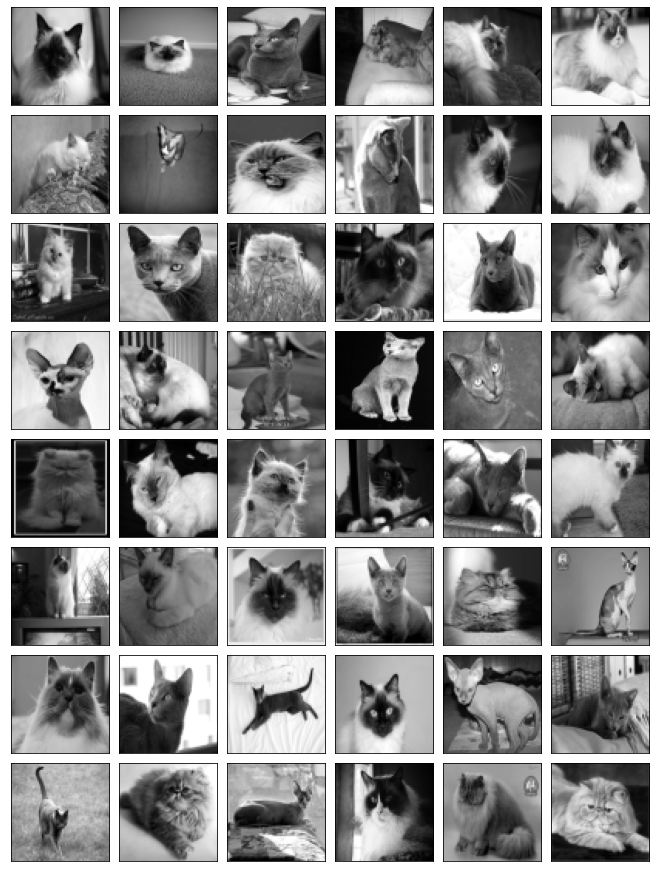


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



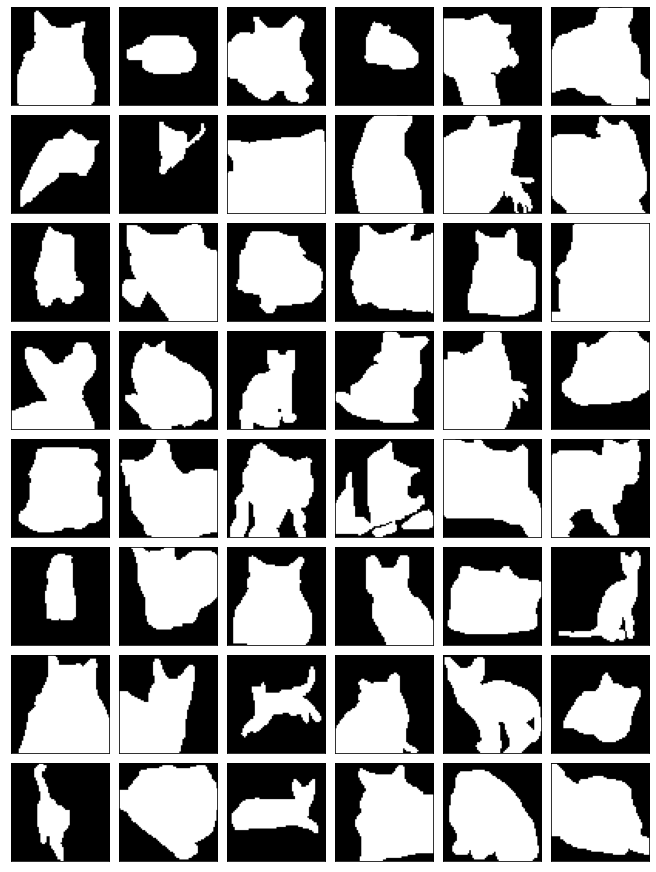


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



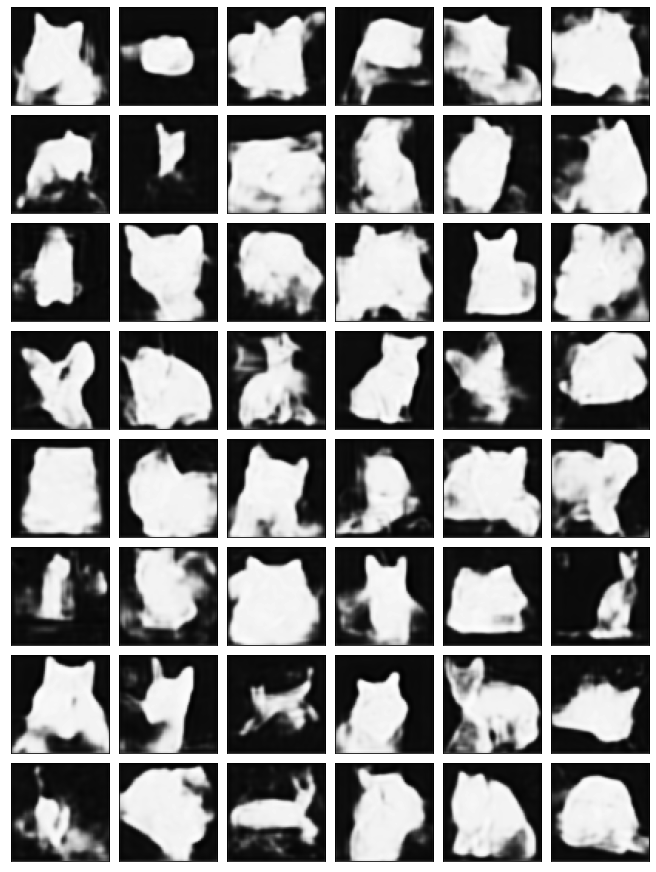


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



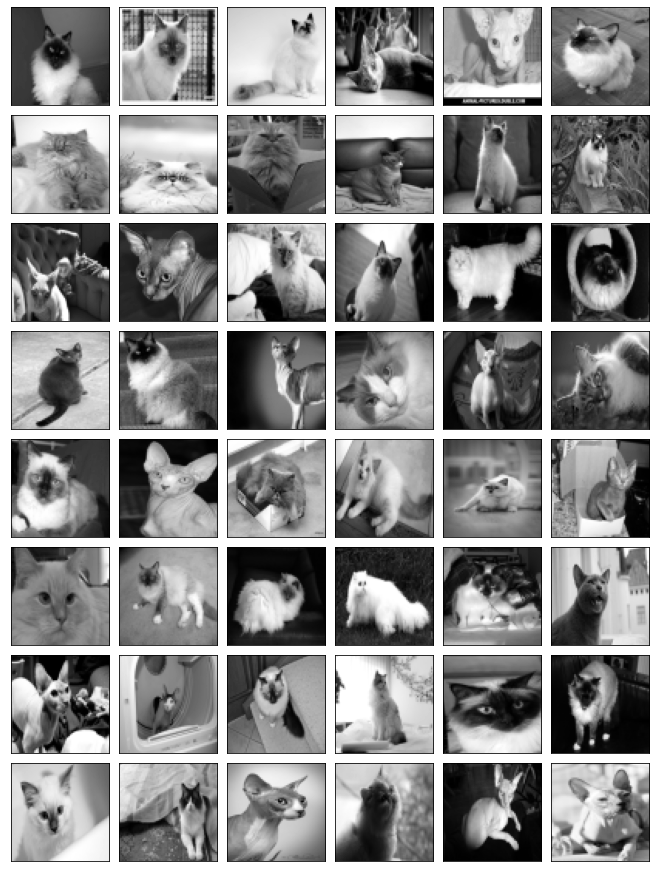


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



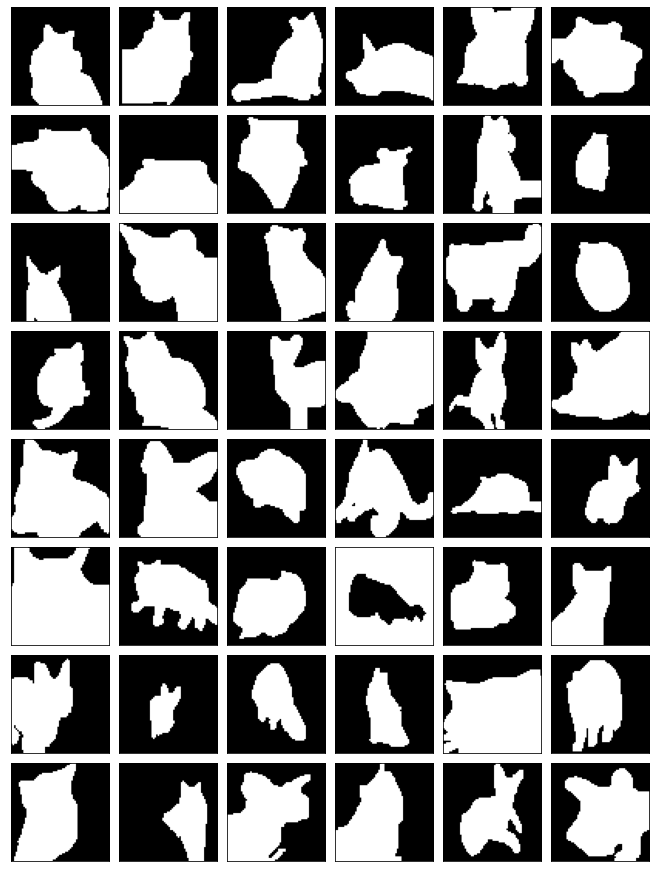


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



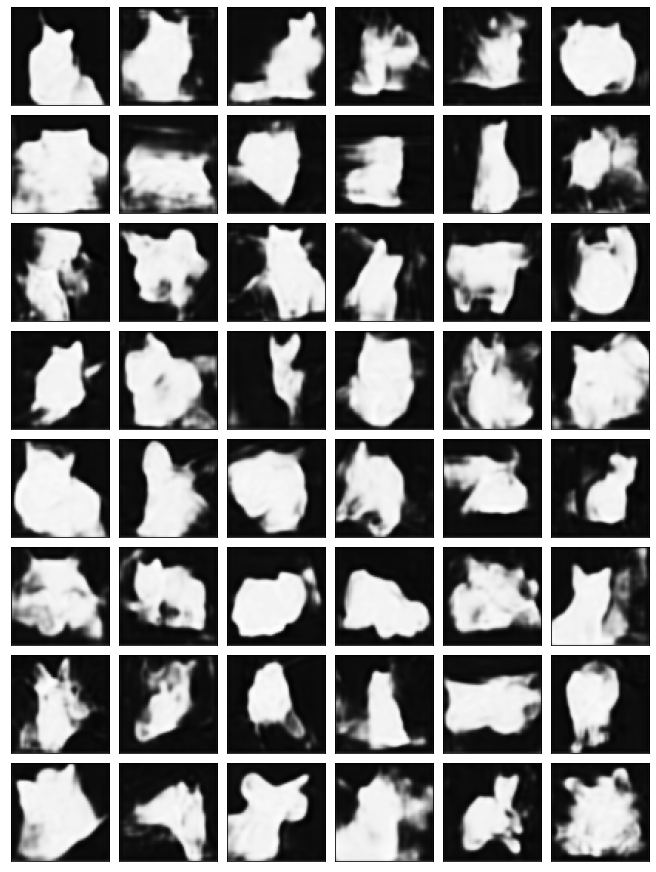


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



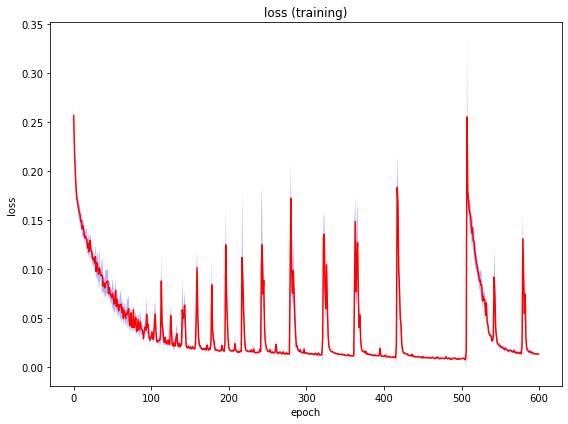


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



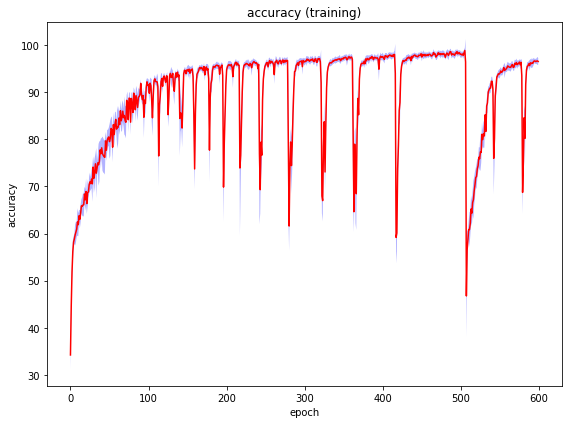


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



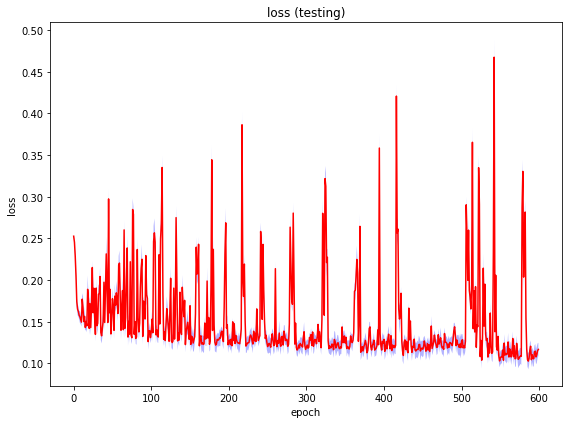


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



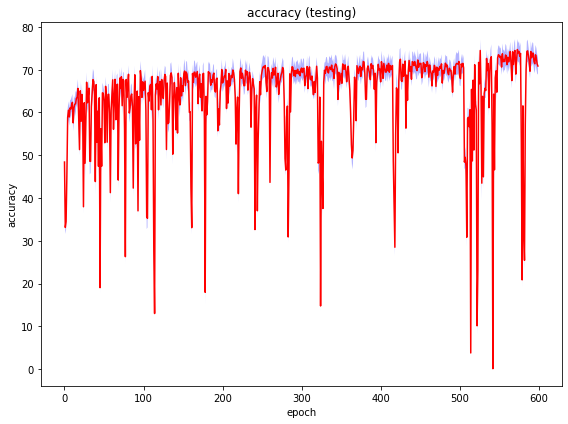


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0152952198
index =  1, value = 0.0147760011
index =  2, value = 0.0147131879
index =  3, value = 0.0139942989
index =  4, value = 0.0135980521
index =  5, value = 0.0135352106
index =  6, value = 0.0136858828
index =  7, value = 0.0135059576
index =  8, value = 0.0132694504
index =  9, value = 0.0135768155

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 96.0809595289
index =  1, value = 96.2076936284
index =  2, value = 96.1478475748
index =  3, value = 96.5265555475
index =  4, value = 96.6573863072
index =  5, value = 96.6273976013


In [235]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)